## 2nd level fMRI analysis: voxel-wise correlation coefficient 
By Willem Huijbers  
1. Setup folder with behavior and contrast images (path)
2. Convert hdr/img (3D) and turn into nii (4D)
3. Calculate pearson correlation coefficients 
5. Visualize correlation maps (volume and surface)

<span style="color:red"> **WH: Warning behavior and contrast maps are not yet matched by SubjID** </span>


In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import plotting
%matplotlib inline

In [2]:
import os
import glob
fp_behav = '/Users/huijbers/Dropbox/SideProjects/Project_with_Sander_cueMEM/cuedMEM/cuedMEM_SubjectLevelData.csv' 
data_behav = pd.read_csv(fp_behav)
#WH drop 15-QR, 33-ZK (no fMRI data)
data_behav = data_behav[data_behav.SubjID != '15-QR']
data_behav = data_behav[data_behav.SubjID != '33-ZK']

#fp = os.getcwd()
fp = '/Users/huijbers/Dropbox/SideProjects/student_folder (for Ruben)/fMRI_with_python/C_OLD_T_OLD_O_HI_gt_F'
os.chdir(fp)


fn = glob.glob('*.img') #assumes matching header (hdr) files

In [43]:
# Match contrast with behavior
data_behav['SubjID'][0] in fn

fn


['1-JA_C_OLD_T_OLD_O_HI_gt_F.img',
 '10-MP_C_OLD_T_OLD_O_HI_gt_F.img',
 '11-IS_C_OLD_T_OLD_O_HI_gt_F.img',
 '12-LJ_C_OLD_T_OLD_O_HI_gt_F.img',
 '13-WW_C_OLD_T_OLD_O_HI_gt_F.img',
 '14-EV_C_OLD_T_OLD_O_HI_gt_F.img',
 '16-LB_C_OLD_T_OLD_O_HI_gt_F.img',
 '17-LD_C_OLD_T_OLD_O_HI_gt_F.img',
 '19-TH_C_OLD_T_OLD_O_HI_gt_F.img',
 '2-RR_C_OLD_T_OLD_O_HI_gt_F.img',
 '20-IB_C_OLD_T_OLD_O_HI_gt_F.img',
 '21-LZ_C_OLD_T_OLD_O_HI_gt_F.img',
 '22-TB_C_OLD_T_OLD_O_HI_gt_F.img',
 '23-GS_C_OLD_T_OLD_O_HI_gt_F.img',
 '24-YQ_C_OLD_T_OLD_O_HI_gt_F.img',
 '25-LK_C_OLD_T_OLD_O_HI_gt_F.img',
 '26-AR_C_OLD_T_OLD_O_HI_gt_F.img',
 '27-GK_C_OLD_T_OLD_O_HI_gt_F.img',
 '28-ES_C_OLD_T_OLD_O_HI_gt_F.img',
 '29-RB_C_OLD_T_OLD_O_HI_gt_F.img',
 '30-SB_C_OLD_T_OLD_O_HI_gt_F.img',
 '31-RD_C_OLD_T_OLD_O_HI_gt_F.img',
 '32-EX_C_OLD_T_OLD_O_HI_gt_F.img',
 '34-KB_C_OLD_T_OLD_O_HI_gt_F.img',
 '35-GT_C_OLD_T_OLD_O_HI_gt_F.img',
 '36-HR_C_OLD_T_OLD_O_HI_gt_F.img',
 '37-RT_C_OLD_T_OLD_O_HI_gt_F.img',
 '39-SH_C_OLD_T_OLD_O_HI_gt_F.

In [3]:
#WH put 3D HDR contrast in 4D array
img = nib.load(os.getcwd() + '/' + fn[0])
image_data = img.get_data()
a = list(image_data.shape)
a.append(1) #Need to add emtpy dimensions to append (4d)
image_data.shape = a

#WH loop trough and add matrixes into 4d array
for ii in range(1, len(fn)):  #len(fn)
    img = nib.load(os.getcwd() + '/' + fn[ii])
    temp = img.get_data()
    a = list(temp.shape)
    a.append(1)
    temp.shape = a
    image_data  = np.append(temp , image_data , axis = 3)   
    #print(image_data.shape)
    #print('done loading' + fn[ii])  

image_data.shape

(53, 63, 54, 43)

Rmap for contrast: C_OLD_T_OLD_O_HI_gt_F


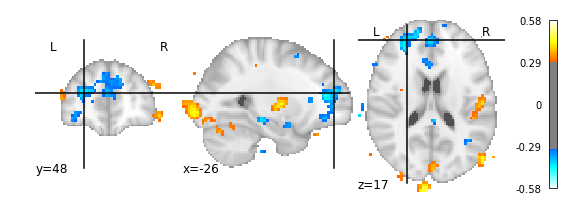

In [29]:
# Calculate a R-map (and visualizes it) --> WH warning is slow (needs a progress bar)
# WH warning (order), ID's need to match between contrast and behavioral measure 

from scipy import stats

mean_behav = data_behav.groupby('SubjID').mean()  #WH temporary fix to make data match subjects
n_subjects = image_data[0,0,0,:].shape[0]
vector = np.reshape(image_data,(np.product(image_data.shape[0:3]),n_subjects),order='F')
r_values = [] #p_values = []
for ii in range(0, np.product(image_data.shape[0:3])):  #53*63*54 = 180306 = np.product(image_data.shape[0:3])
    r,p = stats.pearsonr(mean_behav['dprime'],vector[ii,:])
    r_values = np.append(r_values,r)  
#    p_values = np.append(p_values,p) 
    #if(ii%5000 == 0):
    #print("\r{0}".format((float(ii)/len(vector))*100))  
          
rmap = np.reshape(r_values,(53,63,54),order='F')
#pmap = np.reshape(p_values,(53,63,54),order='F')
img = nib.load(os.getcwd() + '/' + fn[0])
new_rmap = nib.Nifti1Image(rmap, img.affine, img.header)
#new_pmap = nib.Nifti1Image(pmap, img.affine, img.header)
#nib.save(new_img, 'test.nii')
print('Rmap for contrast: ' + fn[0][5:len(fn[0])-4]) #show contrast name based on first subject
plotting.plot_stat_map(new_rmap,threshold=0.3)
plotting.show()

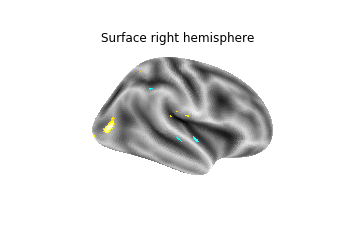

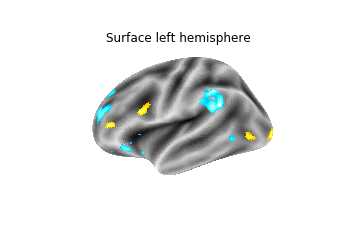

In [30]:
# Plot t-map to surface rendering (from fsaverage)
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage5()
new_rmap = nib.Nifti1Image(np.nan_to_num(rmap), img.affine, img.header)
from nilearn import surface

texture = surface.vol_to_surf(new_rmap, fsaverage.pial_right)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere',
                            threshold=0.3, bg_map=fsaverage.sulc_right,
                            cmap='cold_hot')

texture = surface.vol_to_surf(new_rmap, fsaverage.pial_left)
plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere',
                            threshold=0.3, bg_map=fsaverage.sulc_left,
                            cmap='cold_hot')
plotting.show()